# Imports and Experiment Loading

In [1]:
from src.experiment_handling import load_experiment
import config as cfg
import glob

from src.visualisation import (
    visualise_experiment_results,
    visualise_epochs_before_early_stopping
)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # TrueType fonts
matplotlib.rcParams['ps.fonttype'] = 42

from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use colorblind friendly palette
plt.style.use('tableau-colorblind10')

We automatically load the most recent experiment.

In [2]:
experiments = sorted(glob.glob('./' + cfg.EXP_SAVE_PATH_BASE + '*.yaml'))
experiment = load_experiment(experiments[-1])   # this function just loads a yaml file

print(f'Experiment {experiment['params']['exp']['exp_id']} loaded')

train_size = experiment['params']['exp']['train_size']
n_samples_to_acquire = experiment['params']['al']['n_samples_to_acquire']

ACC_THRESHOLDS = [0.9, 0.95]

SAVE_DIR = './plots'

Experiment 2025-02-20_22-21-17 loaded


# Number of samples needed to reach certain test accuracy (or error)

## Extracting results

In [3]:
# Results of Gal et al. 2017, taken directly from the paper. No per run data i available.

gal_results = {
    0.9:  {'predictive_entropy': 165, 'mutual_information': 145, 'variation_ratios': 120, 'mean_standard_deviation': 230, 'random': 255},
    0.95: {'predictive_entropy': 355, 'mutual_information': 335, 'variation_ratios': 295, 'mean_standard_deviation': 695, 'random': 835}
}

In [4]:
steps_avg = {}
avg_steps = {}

for threshold in ACC_THRESHOLDS:
    steps_avg[threshold] = {}
    avg_steps[threshold] = {}

    for acq_func, results in experiment['results']['acq'].items():
        acc_runs = np.array(results['test_acc'])

        if len(acc_runs) == 0:
            continue

        n_acq_steps = np.argmax(acc_runs > threshold, axis=1) * n_samples_to_acquire + train_size

        steps_avg[threshold][acq_func] = np.sort(n_acq_steps)
        # steps_avg[threshold][acq_func] = n_acq_steps

        avg_run = acc_runs.mean(axis=0)
        n_acq_steps = np.argmax(avg_run > threshold) * n_samples_to_acquire + train_size

        avg_steps[threshold][acq_func] = n_acq_steps

In [5]:
for threshold, results in steps_avg.items():
    print('='*25 + f' {threshold} ' + '='*25)
    print('function                    |    steps    | avg  |  std   || avg steps  || Gal et al.')
    print('-'*90)

    for func, vals in results.items():
        st_avg = steps_avg[threshold][func]
        avg_st = avg_steps[threshold][func]
        print(f"{func:25s}   {st_avg}   {st_avg.mean():.1f}  {st_avg.std():4.1f}   ||    {avg_st}     ||    {gal_results[threshold][func]}")
    print()

========================= 0.9 =========================
function                    |    steps    | avg  |  std   || avg steps  || Gal et al.
------------------------------------------------------------------------------------------
predictive_entropy          [130 130 140]   133.3   4.7   ||    130     ||    165
mutual_information          [100 120 140]   120.0  16.3   ||    130     ||    145
variation_ratios            [100 110 120]   110.0   8.2   ||    110     ||    120
mean_standard_deviation     [120 120 130]   123.3   4.7   ||    120     ||    230
random                      [180 200 200]   193.3   9.4   ||    200     ||    255

========================= 0.95 =========================
function                    |    steps    | avg  |  std   || avg steps  || Gal et al.
------------------------------------------------------------------------------------------
predictive_entropy          [230 240 290]   253.3  26.2   ||    270     ||    355
mutual_information          [240 250 270

## `Step-Averge` vs `Average-Step`

Here we show that when determining how many steps were needed to reach a certain accuracy (or err) value, it makes a difference whether you first determine the steps and then take the average of that, `Step-Average`, or first average the runs and then determine the steps `Average-Step`.

In [6]:
thresholds_met = (steps_avg[0.95]['random'] - train_size) / n_samples_to_acquire
avg_threshold_met = (avg_steps[0.95]['random'] - train_size) / n_samples_to_acquire

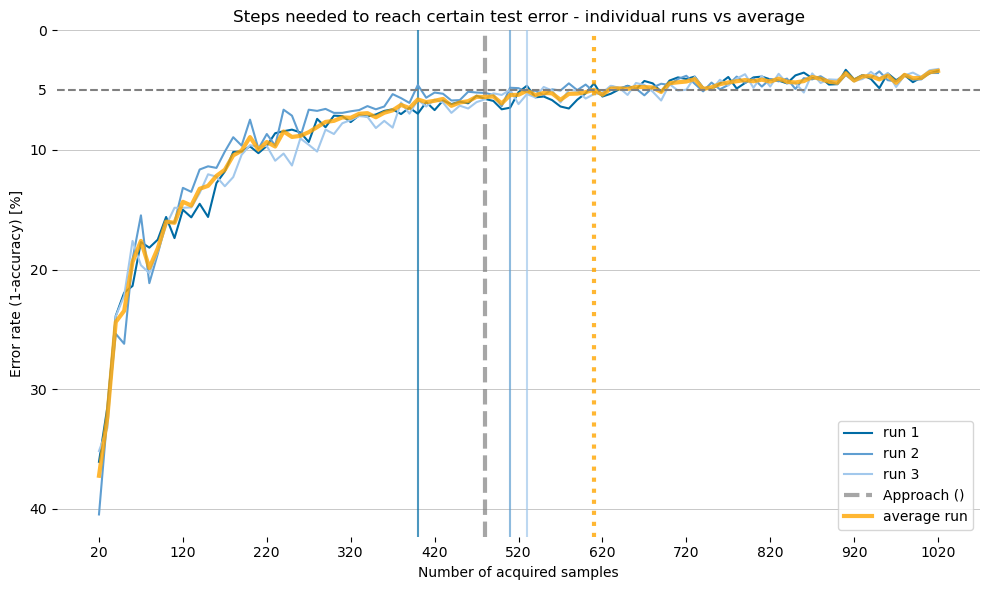

In [7]:
test_acc = np.array(experiment['results']['acq']['random']['test_acc'])
fig, ax = plt.subplots(figsize=(10, 6))

# for i, c in enumerate(['#CC6677', '#AA4499', '#882255']):
for i, c in enumerate(['#006BA4', '#5F9ED1', '#A2C8EC']):
# for i, c in enumerate(['#5F9ED1', '#5F9ED1', '#5F9ED1']):
    ax.plot(test_acc[i], color=c, label=f'run {i+1}')
    # ax.plot(test_acc[i], color=c)
    ax.axvline(thresholds_met[i], color=c, alpha=0.7)

# Average of the points where the individual runs reach the threshold
# ax.axvline(thresholds_met.mean(), color='#5F9ED1', linewidth=3, alpha=0.7, linestyle='dashed')
ax.axvline(thresholds_met.mean(), color='grey', linewidth=3, alpha=0.7, linestyle='dashed', label='Approach ()')

# Average run
ax.plot(np.mean(test_acc, axis=0), color='orange', linewidth=3, alpha=0.8, label='average run')
# Point where the average run reaches the threshold
ax.axvline(avg_threshold_met, color='orange', linewidth=3, alpha=0.8, linestyle='dotted')

# Labels and title
ax.set_ylabel('Error rate (1-accuracy) [%]')
ax.set_xlabel('Number of acquired samples')
ax.set_title('Steps needed to reach certain test error - individual runs vs average')

# Line at 5% error
# ax.text(-9, 0.9463, '5%')
ax.text(-7.3, 0.9463, '5')
ax.axhline(0.95, linestyle='--', color='grey')

# Axes ticks
# ax.set_yticks(np.arange(.6, 1.05, 0.1), [f'{100-n}%' for n in range(60, 101, 10)])
ax.set_yticks(np.arange(.6, 1.05, 0.1), [f'{100-n}' for n in range(60, 101, 10)])
# ax.set_yticks(np.arange(.6, 1.05, 0.1).tolist()+[0.95], [f'{100-n}' for n in list(range(60, 101, 10))+[95]])
ax.set_xticks(
    np.linspace(0, len(acc_runs[0])-1, 11),
    np.linspace(0, len(acc_runs[0])-1, 11, dtype=int) * n_samples_to_acquire + train_size
)

ax.grid(axis='y', linewidth=0.7, alpha=0.7)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Make the layout tight
plt.tight_layout()
plt.show()

fig.savefig(SAVE_DIR + '/random_steps.pdf', format='pdf', dpi=300)

## Absolute comparison

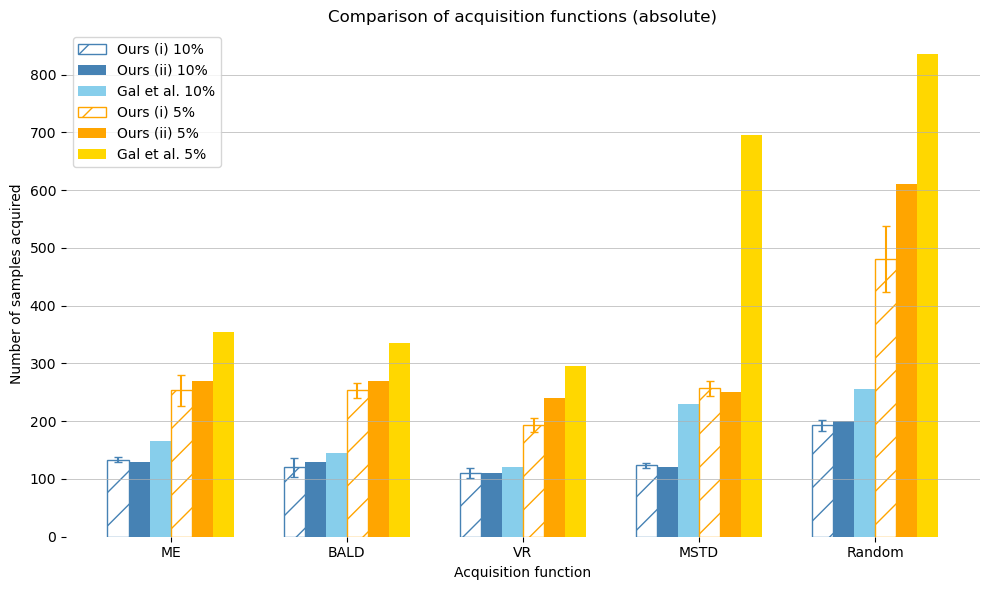

In [8]:
# Acquisition functions
functions = ['ME', 'BALD', 'VR', 'MSTD', 'Random']

x = np.arange(len(functions))  # positions for acquisition functions
width = 0.12  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars: 6 groups for each function (our (i) 90, our (ii) 90, Gal 90, our (i) 95, our (ii) 95, Gal 95)
ax.bar(x - 2.5 * width, np.mean(list(steps_avg[0.9].values()), axis=1), width, label='Ours (i) 10%', color='white', edgecolor='steelblue', hatch='/')
ax.bar(x - 1.5 * width, list(avg_steps[0.9].values()), width, label='Ours (ii) 10%', color='steelblue')
ax.bar(x - 0.5 * width, list(gal_results[0.9].values()), width, label='Gal et al. 10%', color='skyblue')

ax.bar(x + 0.5 * width, np.mean(list(steps_avg[0.95].values()), axis=1), width, label='Ours (i) 5%', color='white', edgecolor='orange', hatch='/')
ax.bar(x + 1.5 * width, list(avg_steps[0.95].values()), width, label='Ours (ii) 5%', color='orange')
ax.bar(x + 2.5 * width, list(gal_results[0.95].values()), width, label='Gal et al. 5%', color='gold')

# Error bars based on standard deviation
ax.errorbar(x - 2.5 * width, np.mean(list(steps_avg[0.9].values()), axis=1), yerr=np.std(list(steps_avg[0.9].values()), axis=1), color='steelblue', linestyle='none', capsize=3)
ax.errorbar(x + 0.5 * width, np.mean(list(steps_avg[0.95].values()), axis=1), yerr=np.std(list(steps_avg[0.95].values()), axis=1), color='orange', linestyle='none', capsize=3)

# Add baseline line at 1.0
# ax.axhline(1.0, color='red', linestyle='--', linewidth=1)

# Labels and title
ax.set_ylabel('Number of samples acquired')
ax.set_xlabel('Acquisition function')
ax.set_title('Comparison of acquisition functions (absolute)')
ax.set_xticks(range(len(functions)))
ax.set_xticklabels(functions)
# ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.grid(axis='y', linewidth=0.7, alpha=0.7)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Make the layout tight
plt.tight_layout()
plt.show()

# Save a high resolution version
fig.savefig(SAVE_DIR + '/acquisition_function_comparison_abs.pdf', format='pdf', dpi=300)

## Relative comparison

To compare our results with those of Gal et al. (2017), we normalize each value by dividing it by the corresponding result of the random acquisition baseline.

For example, in our experiments, reaching 90% accuracy required **130** samples for `BALD` and *200* for `Random`, whereas Gal et al. reported **145** for `BALD` and *255* for `Random`.
After normalization, this means `BALD` achieved 90% accuracy using **65%** of the samples compared to the random baseline in our experiments, and **56%** in Gal et al.’s results.

In [9]:
def relativize_results(results: dict, dict_key='random', verbose: bool = False):

    baseline = np.mean(results[dict_key])
    results_rel = {key: value/baseline for key, value in results.items() if key != dict_key}

    if verbose:
        print(f"baseline :: {baseline:.1f}")

    return results_rel

In [10]:
print(steps_avg[0.9]['random'])
print(avg_steps[0.9]['random'])
print(gal_results[0.9]['random'])

[180 200 200]
200
255


In [11]:
for data, name in [(steps_avg, 'step_avg'), (avg_steps, 'avg_steps'), (gal_results, 'gal et al.')]:
    print(name)
    for threshold in [0.9, 0.95]:
        vals = data[threshold]['random']
        baseline = np.mean(vals)
        norm_vals = vals / baseline
        print(f"{threshold:.2f}  :: {norm_vals.round(2)} :: {norm_vals.mean().round(2)} :: {norm_vals.std().round(3)}")
    print()

step_avg
0.90  :: [0.93 1.03 1.03] :: 1.0 :: 0.049
0.95  :: [0.83 1.06 1.1 ] :: 1.0 :: 0.119

avg_steps
0.90  :: 1.0 :: 1.0 :: 0.0
0.95  :: 1.0 :: 1.0 :: 0.0

gal et al.
0.90  :: 1.0 :: 1.0 :: 0.0
0.95  :: 1.0 :: 1.0 :: 0.0



In [12]:
steps_avg_rel = {}
avg_steps_rel = {}
gal_rel = {}


for threshold in ACC_THRESHOLDS:
    steps_avg_rel[threshold] = relativize_results(steps_avg[threshold])
    avg_steps_rel[threshold] = relativize_results(avg_steps[threshold])
    gal_rel[threshold] = relativize_results(gal_results[threshold])

In [13]:
for threshold, results in steps_avg_rel.items():
    print('='*25 + f' {threshold} ' + '='*25)
    print('function                    |    steps    | avg  |  std     || avg steps || Gal et al.')
    print('-'*90)

    for func, vals in results.items():
        st_avg = steps_avg_rel[threshold][func]
        avg_st = avg_steps_rel[threshold][func]
        print(f"{func:25s}   {st_avg.round(2)}   {st_avg.mean():.2f}  {st_avg.std():4.3f}   ||   {avg_st:.2f}    ||   {gal_rel[threshold][func]:.2f}")
    print()

========================= 0.9 =========================
function                    |    steps    | avg  |  std     || avg steps || Gal et al.
------------------------------------------------------------------------------------------
predictive_entropy          [0.67 0.67 0.72]   0.69  0.024   ||   0.65    ||   0.65
mutual_information          [0.52 0.62 0.72]   0.62  0.084   ||   0.65    ||   0.57
variation_ratios            [0.52 0.57 0.62]   0.57  0.042   ||   0.55    ||   0.47
mean_standard_deviation     [0.62 0.62 0.67]   0.64  0.024   ||   0.60    ||   0.90

========================= 0.95 =========================
function                    |    steps    | avg  |  std     || avg steps || Gal et al.
------------------------------------------------------------------------------------------
predictive_entropy          [0.48 0.5  0.6 ]   0.53  0.055   ||   0.44    ||   0.43
mutual_information          [0.5  0.52 0.56]   0.53  0.026   ||   0.44    ||   0.40
variation_ratios          

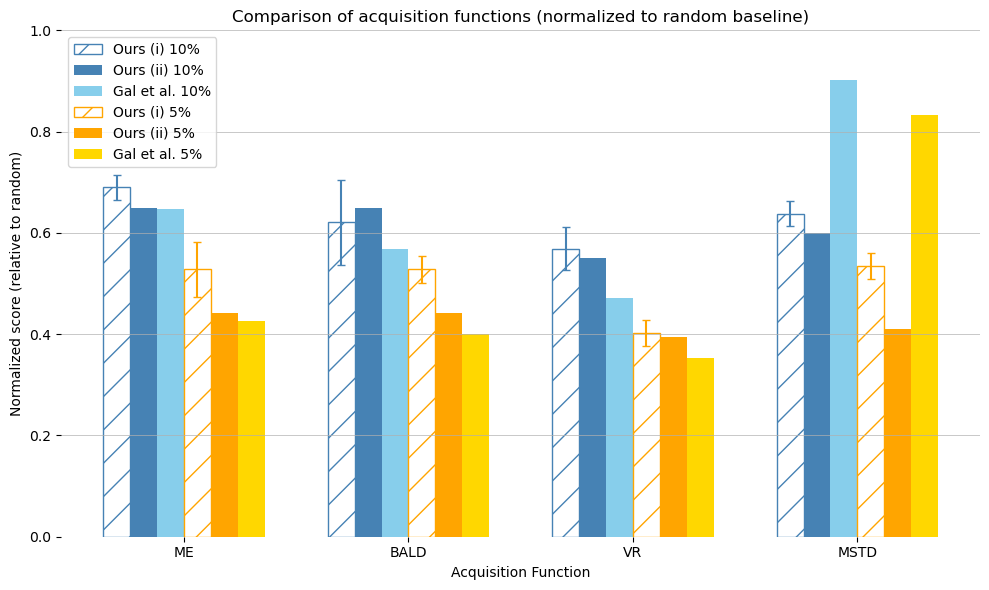

In [14]:
# Acquisition functions
functions = ['ME', 'BALD', 'VR', 'MSTD']

x = np.arange(len(functions))  # positions for acquisition functions
width = 0.12  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars: 6 groups for each function (our (i) 90, our (ii) 90, Gal 90, our (i) 95, our (ii) 95, Gal 95)
ax.bar(x - 2.5 * width, np.mean(list(steps_avg_rel[0.9].values()), axis=1), width, label='Ours (i) 10%', color='white', edgecolor='steelblue', hatch='/')
ax.bar(x - 1.5 * width, list(avg_steps_rel[0.9].values()), width, label='Ours (ii) 10%', color='steelblue')
ax.bar(x - 0.5 * width, list(gal_rel[0.9].values()), width, label='Gal et al. 10%', color='skyblue')

ax.bar(x + 0.5 * width, np.mean(list(steps_avg_rel[0.95].values()), axis=1), width, label='Ours (i) 5%', color='white', edgecolor='orange', hatch='/')
ax.bar(x + 1.5 * width, list(avg_steps_rel[0.95].values()), width, label='Ours (ii) 5%', color='orange')
ax.bar(x + 2.5 * width, list(gal_rel[0.95].values()), width, label='Gal et al. 5%', color='gold')

# Error bars based on standard deviation
ax.errorbar(x - 2.5 * width, np.mean(list(steps_avg_rel[0.9].values()), axis=1), yerr=np.std(list(steps_avg_rel[0.9].values()), axis=1), color='steelblue', linestyle='none', capsize=3)
ax.errorbar(x + 0.5 * width, np.mean(list(steps_avg_rel[0.95].values()), axis=1), yerr=np.std(list(steps_avg_rel[0.95].values()), axis=1), color='orange', linestyle='none', capsize=3)

# Add baseline line at 1.0
# ax.axhline(1.0, color='red', linestyle='--', linewidth=1)

# Labels and title
ax.set_ylabel('Normalized score (relative to random)')
ax.set_xlabel('Acquisition Function')
ax.set_title('Comparison of acquisition functions (normalized to random baseline)')
ax.set_xticks(range(len(functions)))
ax.set_xticklabels(functions)
ax.set_yticks(np.arange(0, 1.1, 0.2))
# ax.axhline(1.0, linestyle='--', color='grey')
ax.grid(axis='y', linewidth=0.7, alpha=0.7)
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Make the layout tight
plt.tight_layout()
plt.show()

# Save a high resolution version
fig.savefig(SAVE_DIR + '/acquisition_function_comparison_rel.pdf', format='pdf', dpi=300)

# Test set accuracy and mutual information per acquisition step

Here we plot the performance in terms of test set accuracy and mutual information for each acquisition step.
To do so, we average the accuracy and mutual information results of all three runs into one run.
We show the **average** as well as the **standard deviation**.

In [15]:
# This cell changes the full length names of the acquisition functions to shorter names for plotting
from copy import deepcopy

_exp_temp = deepcopy(experiment)
# change keys to shorter names EM, BALD, VR, MSTD, RANDOM
_exp_temp['results']['acq'] = {
    k.replace('predictive_entropy', 'ME')
     .replace('mutual_information', 'BALD')
     .replace('variation_ratios', 'VR')
     .replace('mean_standard_deviation', 'MSTD')
     .replace('random', 'Random'):
        v for k, v in _exp_temp['results']['acq'].items()
}

print(experiment['results']['acq'].keys())
print(_exp_temp['results']['acq'].keys())

dict_keys(['predictive_entropy', 'mutual_information', 'variation_ratios', 'mean_standard_deviation', 'random'])
dict_keys(['ME', 'BALD', 'VR', 'MSTD', 'Random'])


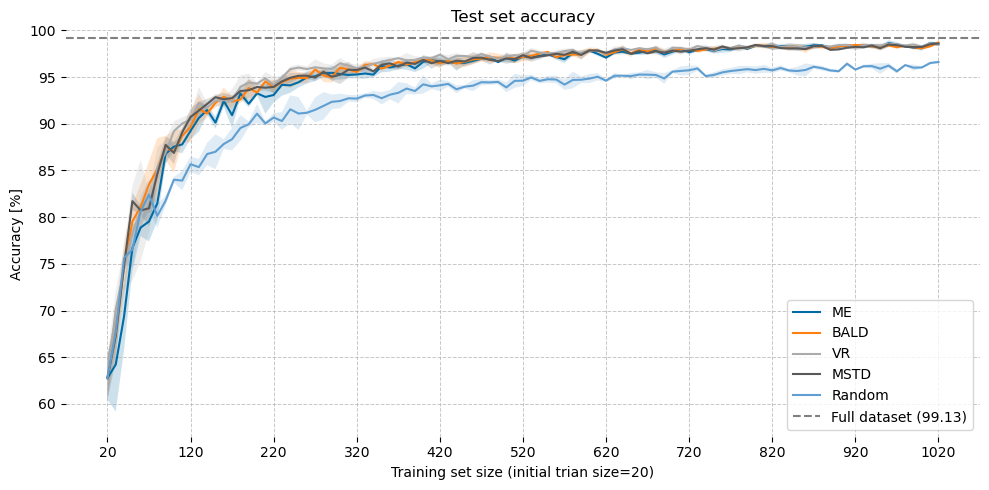

In [16]:
visualise_experiment_results(_exp_temp, ['acc'], save_path=SAVE_DIR)

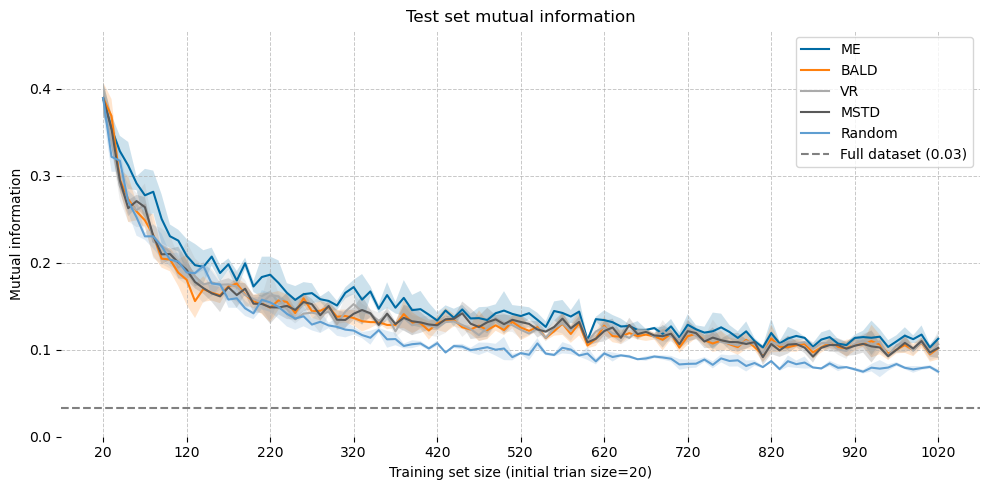

In [17]:
visualise_experiment_results(_exp_temp, ['inf'], save_path=SAVE_DIR)

# Early stopping

Here we show the average number of epochs before early stopping, averaged over the three runs and additionally a moving average over that. The shaded area indicates the moving average of the standard deviation between the three runs.

What is interesting to me is that it seems like the four acquisition functions typically train for longer than `Random`, and that the training time increases with dataset size.

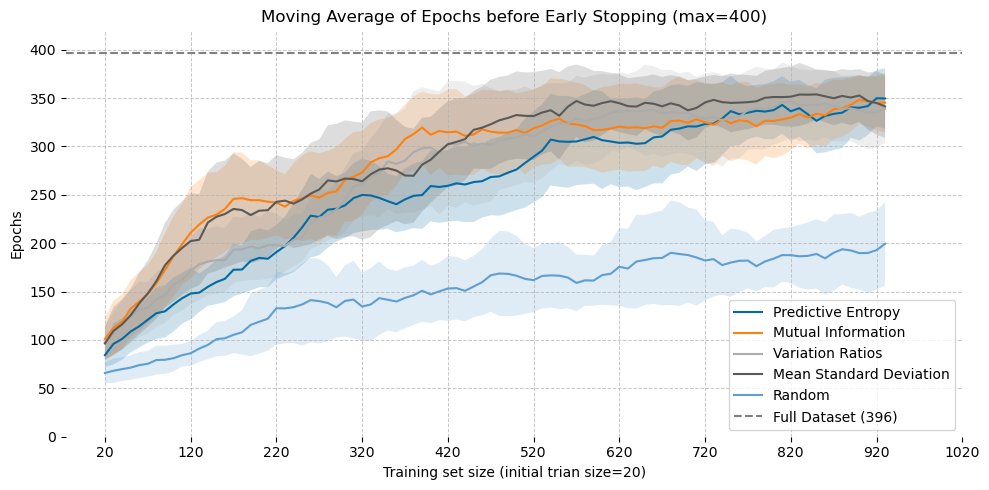

In [18]:
visualise_epochs_before_early_stopping(experiment)

# MNIST example

Here we plot a high resolution example of thirty MNIST samples, three from each class.

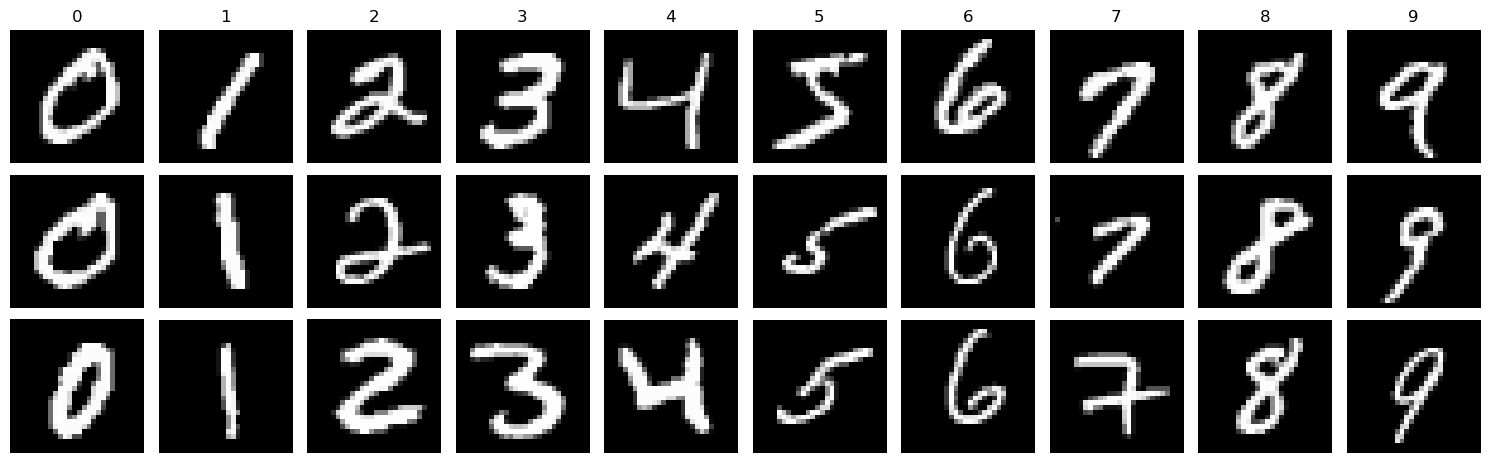

In [19]:
# plot an example of each digit from the MNIST dataset
mnist = datasets.MNIST('../data/mnist', download=True)
fig, axes = plt.subplots(3, 10, figsize=(15, 9))

# plot two of each number
for digit in range(10):
    indices = np.where(mnist.targets == digit)[0]
    for i in range(3):
        ax = axes[i, digit]
        ax.imshow(mnist.data[indices[i]], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'{digit}', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.75)
plt.show()

fig.savefig(SAVE_DIR + '/mnist_example.pdf', format='pdf', dpi=300, bbox_inches='tight')